In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sns.set(style = "darkgrid",font_scale =1.2)
plt.rcParams["font.family"] = "Simhei"
plt.rcParams["axes.unicode_minus"] = False
pd.plotting.register_matplotlib_converters()

In [2]:
#数据加载
data = pd.read_csv("transformer.csv")
print(data.shape)
data.head()

(477, 3)


,Unnamed: 0,Month,value
0,0,Jan-1979,95.9
1,1,Feb-1979,82.8
2,2,Apr-1978,77.1
3,3,Mar-1979,83.3
4,4,Apr-1979,80.0


In [3]:
#删除无关列
data = data.drop(["Unnamed: 0"], axis=1)

In [4]:
#将Month转化为日期格式
data["Month"] = data["Month"].astype("datetime64").dt.strftime("%Y-%m")
data.head()

,Month,value
0,1979-01,95.9
1,1979-02,82.8
2,1978-04,77.1
3,1979-03,83.3
4,1979-04,80.0


In [5]:
#数据清洗
data.isnull().sum()

Month    0
value    1
dtype: int64

In [6]:
#按月份对数据排序，使其成为有序序列
data.sort_values("Month",inplace = True)
data.head()

,Month,value
13,1978-01,93.2
14,1978-02,96.0
15,1978-03,95.2
2,1978-04,77.1
16,1978-06,64.8


In [7]:
#使用插值填充缺失值
data["value"].interpolate(inplace = True)
data.isnull().sum()

Month    0
value    0
dtype: int64

findfont: Font family ['Simhei'] not found. Falling back to DejaVu Sans.


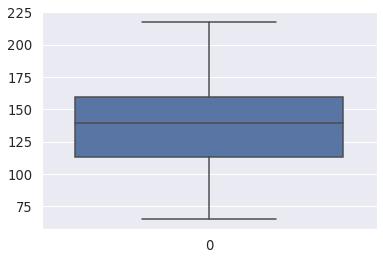

In [8]:
#查看异常值
sns.boxplot(data = data["value"])
plt.show()

In [9]:
#查看重复值
data.duplicated(subset =["Month"]).sum()

2

In [10]:
data[data.duplicated(keep = False)]

,Month,value
29,1980-07,74.8
77,1980-07,74.8
395,2010-11,210.5
209,2010-11,210.5


In [11]:
#删除重复值
data.drop_duplicates(inplace = True)
data.shape

(475, 2)

In [12]:
#设置Month为索引
data["Month"] = pd.to_datetime(data["Month"])
data.set_index(["Month"],inplace =True)
data

,value
Month,
1978-01-01,93.2
1978-02-01,96.0
1978-03-01,95.2
1978-04-01,77.1
1978-06-01,64.8
...,...
2017-04-01,127.0
2017-05-01,151.0
2017-06-01,130.0


In [13]:
#时间点检测，时间序列需要检测时间点是否缺失
data = data.asfreq("MS")
data.isnull().sum()

value    1
dtype: int64

In [14]:
#对缺失值进行插值
data.interpolate(inplace = True)
data.head()

,value
Month,
1978-01-01,93.20
1978-02-01,96.00
1978-03-01,95.20
1978-04-01,77.10
1978-05-01,70.95


In [15]:
data.isnull().sum()

value    0
dtype: int64

findfont: Font family ['Simhei'] not found. Falling back to DejaVu Sans.


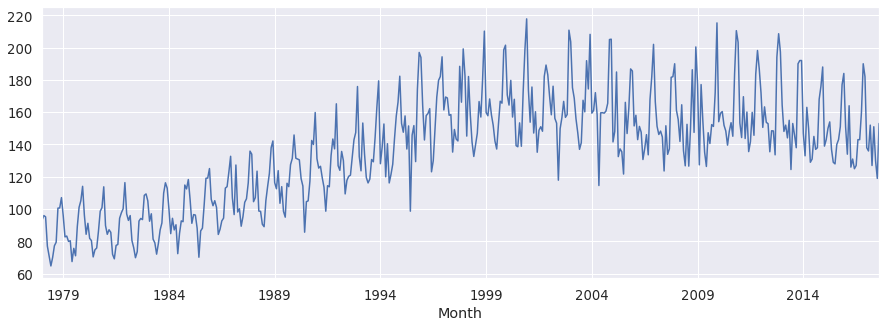

In [16]:
#时间序列可视化
data["value"].plot(figsize = (15,5))
plt.show()

## 使用ARIMA模型

findfont: Font family ['Simhei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Simhei'] not found. Falling back to DejaVu Sans.


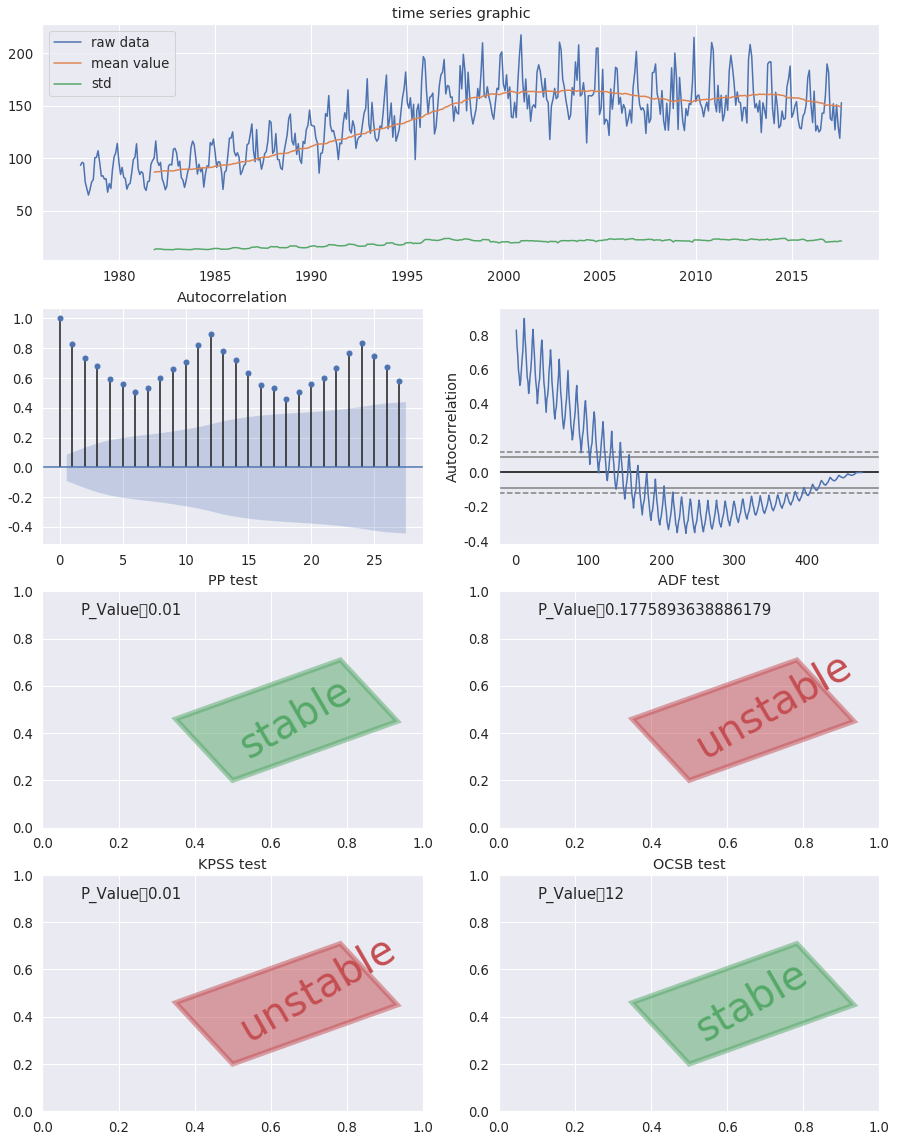

In [17]:
#数据平稳性检验
import tstools

tstools.stationarity_test(data["value"],m =12)

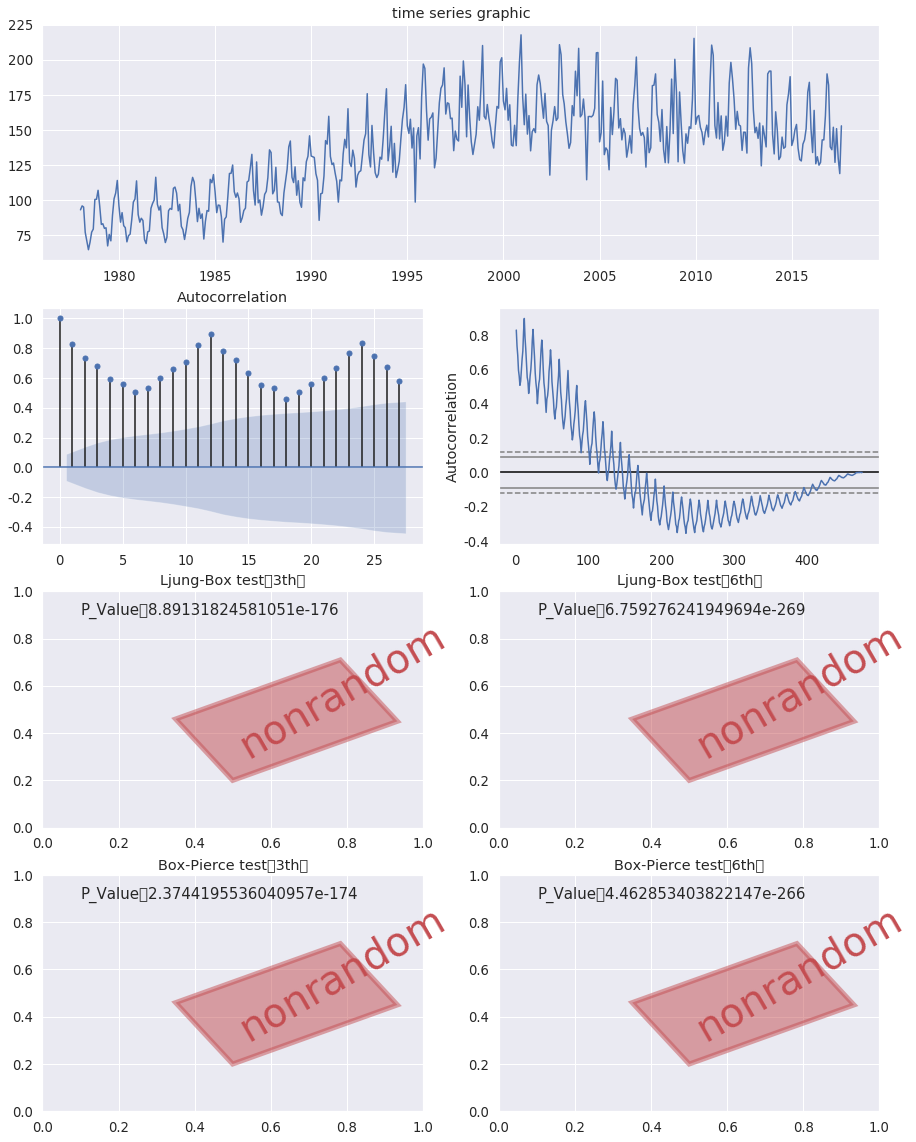

In [18]:
#随机性检验
tstools.random_test(data["value"])

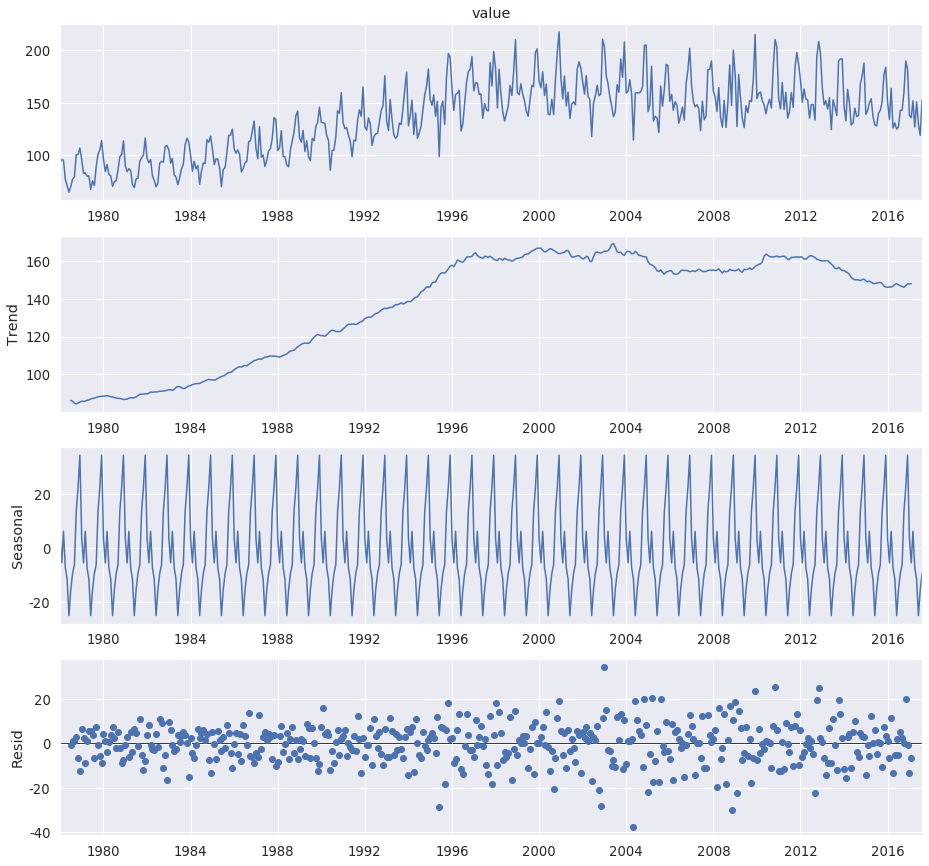

In [19]:
#将趋势分解为趋势，周期和随机性（残差）
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data["value"])
f = result.plot()
f.set_size_inches(15,15)
plt.subplots_adjust(hspace = 0.2)
plt.show()

In [20]:
#数据建模
#基模型
#切分数据集，将数据集切分为训练集和测试集
from pmdarima.model_selection import train_test_split

train,test = train_test_split(data,test_size = 12)
print(train.shape)
print(test.shape)

(464, 1)
(12, 1)


In [21]:
#使用过去三个月的均值作为预测值，结果作为baseline模型
HISTORY_SIZE = 3

#取出测试集+历史数据的长度用于预测
s = data["value"].iloc[-(test.shape[0] + HISTORY_SIZE):]
#以历史数据长度作为滑动窗口
t = s.rolling(window = HISTORY_SIZE).mean()
hat = t.shift(1).dropna()

In [22]:
#预测结果可视化
def plot_predict(hat,ci = None):
    """
    绘制预测结果图像
    用来绘制训练集，测试集，预测结果及置信区间
    Parameters
    ------------
    hat:array-like,模型预测值
    ci:array-like,可选，每个预测结果的置信区间
    """
    #为了更清晰展示数据，只展示训练数据一小部分
    train["value"].iloc[-15:].plot(figsize=(15,5),marker = "o",label = "tainset")
    test["value"].plot(marker = "o",label = "testset")
    pd.Series(hat,index = test.index).plot(marker = "o",label = "predict value")
    if ci is not None:
        plt.fill_between(test.index,ci[:,0],ci[:,1],color = "green",alpha = 0.2)
    a, b = plt.xlim()
    plt.xlim(a-1,b+1)
    plt.legend()
    plt.show()    

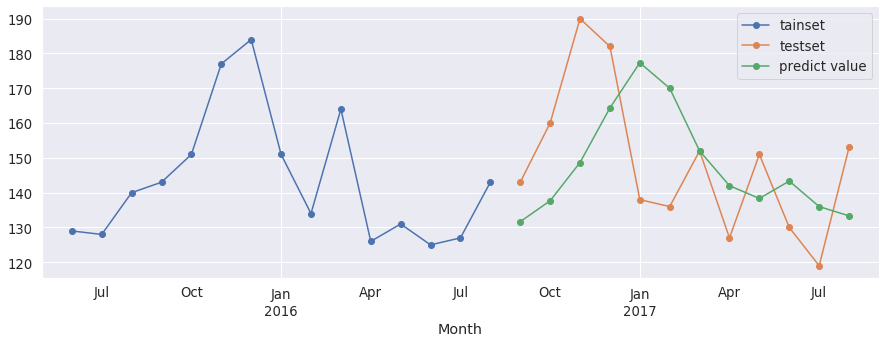

In [23]:
plot_predict(hat)

In [24]:
#模型评估，使用r2指标
from sklearn.metrics import r2_score

print(r2_score(test["value"],hat))

-0.32143553409198544


In [25]:
#ARIMA分析
import pmdarima as pm

#输出对应检验最合适的差分
print(pm.arima.ndiffs(train["value"],test = "adf"))
print(pm.arima.ndiffs(train["value"],test = "kpss"))
print(pm.arima.ndiffs(train["value"],test = "pp"))
#周期性检验
for i in range(10,30):
    if pm.arima.nsdiffs(train["value"],m = i,test = "ocsb") or \
    pm.arima.nsdiffs(train["value"],m = i,test = "ch"):
        print(i)

0
1
0


In [26]:
#按无周期寻找模型参数
arima = pm.auto_arima(train["value"],seasonal = False,step_wise = True,
                     suppress_warnings = True,error_action = "ignore",trace = True)
print(arima.order)
print(arima.seasonal_order)
#输出模型总结信息
display(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3952.460, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4070.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4047.058, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4037.365, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4068.306, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4013.979, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4028.078, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3953.390, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3954.004, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3957.113, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3960.437, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3958.798, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3953.793, Time=0.22 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  464
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1970.230
Date:                Sat, 02 Jan 2021   AIC                           3952.460
Time:                        12:59:45   BIC                           3977.286
Sample:                             0   HQIC                          3962.233
                                - 464                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1431      0.076      1.884      0.060      -0.006       0.292
ar.L1         -0.3161      0.101     -3.126      0.002      -0.514      -0.118
ar.L2          0.3261      0.075      4.362      0.000       0.180       0.473
ma.L1         -0.1055      0.082     -1.287      0.198      -0.266       0.055
ma.L2         -0.8085      0.082     -9.887      0.000      -0.969      -0.648
sigma2       289.8759     18.516     15.655      0.000     253.585     326.167
===================================================================================
Ljung-Box (Q):                      889.75   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               3.33   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

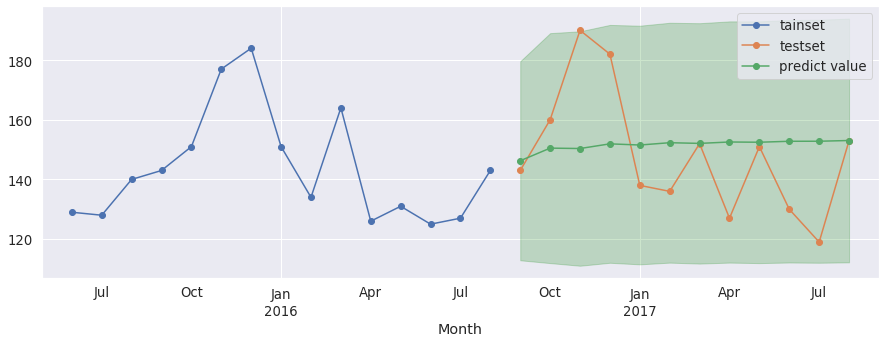

In [27]:
#使用模型进行预测
hat,ci = arima.predict(n_periods = test.shape[0],return_conf_int = True)
plot_predict(hat,ci)

In [28]:
#模型评估
print(r2_score(test["value"],hat))

-0.0714282097933665


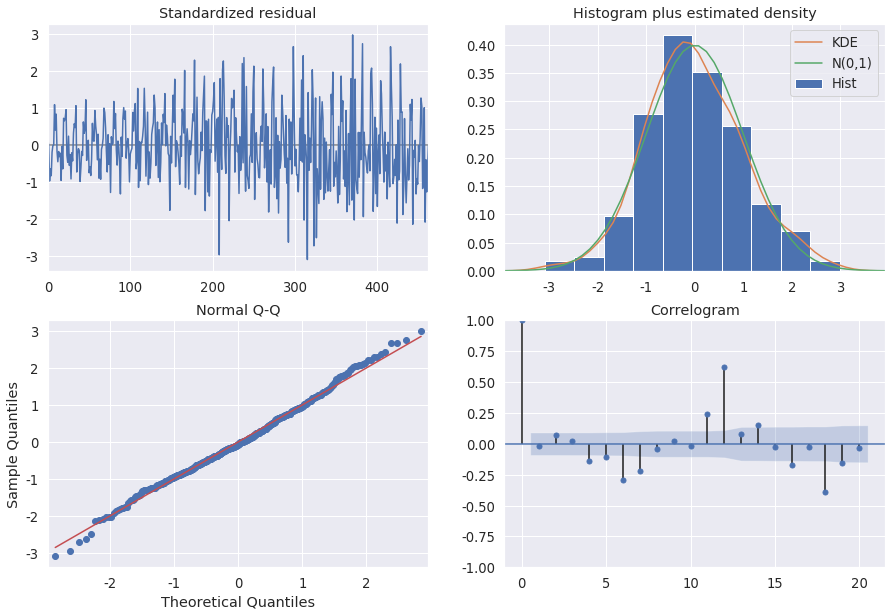

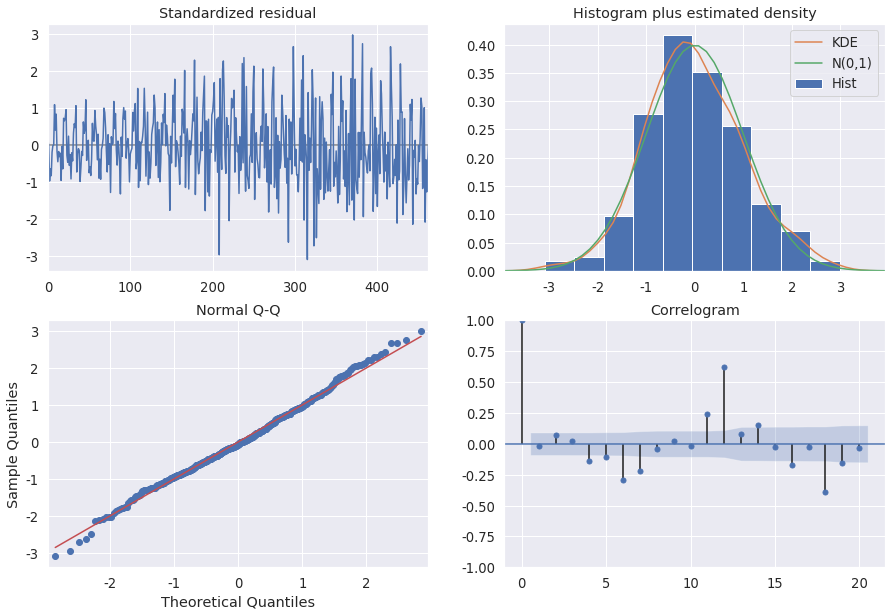

In [29]:
#绘制残差诊断图
arima.plot_diagnostics(figsize =(15,10),lags =20)

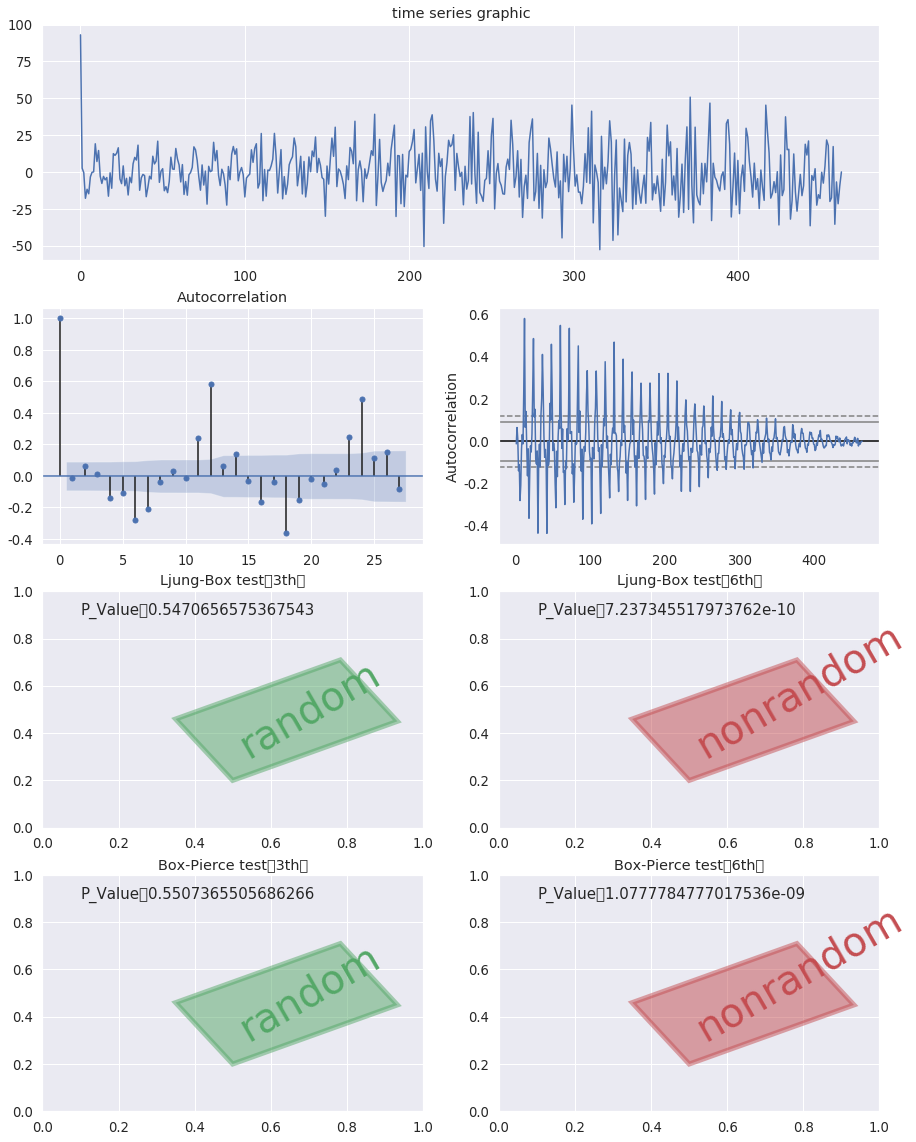

In [30]:
#残差检验
tstools.random_test(arima.resid())

In [31]:
#指定周期为12重新建模
arima = pm.auto_arima(train["value"],m =12,seasonal = True,stepwise = True,
                     suppress_warnings =True,error_action = "ignore",trace =True)
display(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3467.866, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4070.292, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3807.863, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3839.734, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4068.306, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3799.094, Time=0.74 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3473.272, Time=4.93 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3467.239, Time=4.80 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3715.548, Time=2.08 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=3505.989, Time=3.92 sec
 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=3469.468, Time=4.86 sec
 ARIMA(2,1,3)(1,0,2)[12] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  464
Model:             SARIMAX(3, 1, 4)x(1, 0, [1, 2], 12)   Log Likelihood               -1688.000
Date:                                 Sat, 02 Jan 2021   AIC                           3400.001
Time:                                         13:02:16   BIC                           3449.654
Sample:                                              0   HQIC                          3419.548
                                                 - 464                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.116e-05      0.005     -0.012      0.991      -0.010       0.010
ar.L1         -0.3310      0.082     -4.056      0.000      -0.491      -0.171
ar.L2         -0.0495      0.093     -0.531      0.595      -0.232       0.133
ar.L3          0.8155      0.081     10.096      0.000       0.657       0.974
ma.L1         -0.6814      0.068     -9.978      0.000      -0.815      -0.548
ma.L2         -0.2068      0.029     -7.208      0.000      -0.263      -0.151
ma.L3         -0.8132      0.024    -33.849      0.000      -0.860      -0.766
ma.L4          0.8047      0.054     14.926      0.000       0.699       0.910
ar.S.L12       0.9898      0.007    151.656      0.000       0.977       1.003
ma.S.L12      -0.7981      0.048    -16.705      0.000      -0.892      -0.704
ma.S.L24       0.0305      0.046      0.667      0.504      -0.059       0.120
sigma2        81.8903      4.631     17.684      0.000      72.814      90.966
===================================================================================
Ljung-Box (Q):                       55.85   Jarque-Bera (JB):                56.19
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.44   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

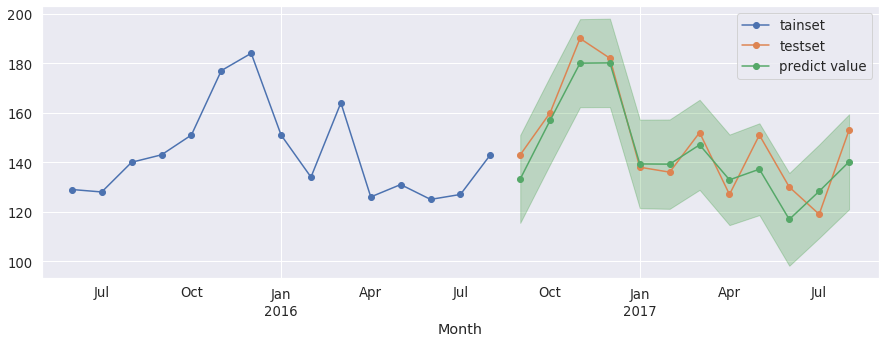

In [32]:
#模型评估
hat,ci = arima.predict(n_periods = test["value"].shape[0],return_conf_int = True)
plot_predict(hat,ci)

In [33]:
#计算r2值
print(r2_score(test["value"],hat))

0.8213702503311778


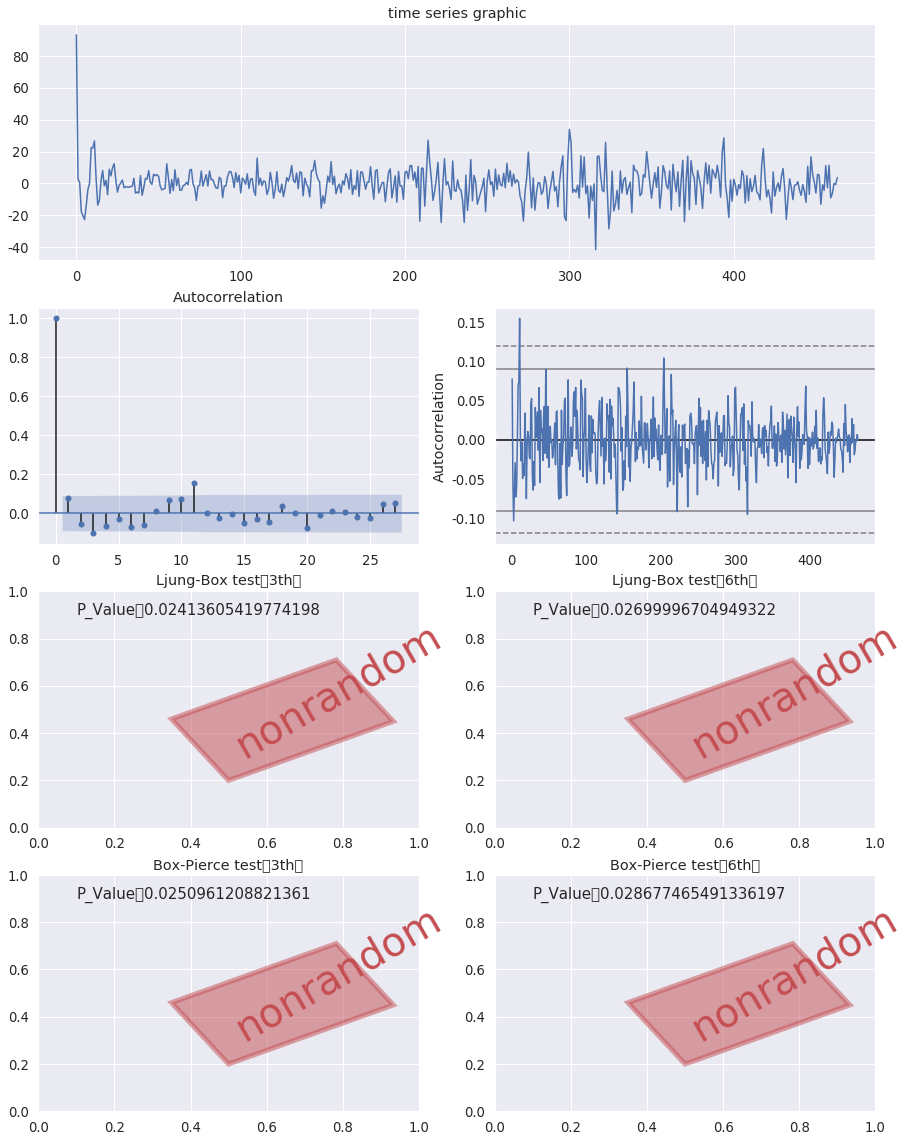

In [34]:
#残差诊断
tstools.random_test(arima.resid())

## 使用MLP模型

In [35]:
#数据规范化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_train = scaler.fit_transform(train)
scaler_test = scaler.transform(test)
print(scaler_train[:3])
print(scaler_test[:3])
scaled_data = np.concatenate([scaler_train, scaler_test], axis=0)
scaled_data = scaled_data.ravel()
print(scaled_data.shape)

[[-1.2642176 ]
 [-1.18167492]
 [-1.20525854]]
[[0.20386303]
 [0.70501505]
 [1.58940097]]
(476,)


In [36]:
#构建训练集
def create_X_y(ts, X_size, y_size, start=0, end=None):
    """
    用于从时间序列提取数据，构建X,y训练数据。
    在时间序列ts中，以X_size长度数据作为X,其随后y_size长度数据作为y.
    依次对ts进行遍历，ts有效区间为[start, end]
    
    Parameters
    ------------
    ts: array_like 时间序列数组
    X_size: int X的长度
    y_size: int y的长度
    start: int 可选，开始位置索引(包含)，默认为0
    end: int 可选，结束位置索引(不包含), 默认为ts长度
    
    Returns
    -----------------
    X: ndarray 训练数据中的X.
    y: ndarray 训练数据中的y    
    """
    X, y = [], []
    s = start + X_size
    e = len(ts) if end is None else end
    data = np.asarray(ts)
    #i为预测元素的位置(单元素),预测元素的起始位置(多元素)
    for i in range(s, e):
        X.append(data[i - X_size:i])
        y.append(data[i:i + y_size])
    return np.array(X), np.array(y)    

In [37]:
#定义训练集与测试集的切分点
split = data.shape[0] - test.shape[0]
X_size, y_size = 10, 1
X_train, y_train = create_X_y(scaled_data, X_size, y_size, 0, split)
X_test, y_test = create_X_y(scaled_data, X_size, y_size, split-X_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(454, 10) (454, 1)
(12, 10) (12, 1)


In [38]:
import tensorflow as tf

#创建MLP模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation="relu", input_dim=X_size))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation="linear"))

In [39]:
import tensorflow.keras.backend as K

def r2_score_custom(y_true, y_pred):
    """
    自定义评估函数
    该函数实现求解r2_score的功能
    Parameters
    -----------
    y_true: Tensor 真实标签值
    y_pred: Tensor 预测标签值
    
    Returns
    --------
    r2 :Tensor R^2值
    """
    rss = K.sum(K.square(y_true - y_pred))
    tss = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - rss / (tss + K.epsilon())    

In [40]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[r2_score_custom])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "MLP/params.ckpt",
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True)

earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience=5)

history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[callback,earlystop])

Epoch 1/100
53/57 [==========================>...] - ETA: 0s - loss: 0.4053 - r2_score_custom: 0.4440
Epoch 00001: val_loss improved from inf to 0.28561, saving model to MLP/params.ckpt
57/57 [==============================] - 1s 12ms/step - loss: 0.3940 - r2_score_custom: 0.4633 - val_loss: 0.2856 - val_r2_score_custom: -0.0205
Epoch 2/100
52/57 [==========================>...] - ETA: 0s - loss: 0.2340 - r2_score_custom: 0.6933
Epoch 00002: val_loss improved from 0.28561 to 0.24950, saving model to MLP/params.ckpt
57/57 [==============================] - 0s 6ms/step - loss: 0.2294 - r2_score_custom: 0.6999 - val_loss: 0.2495 - val_r2_score_custom: -0.1318
Epoch 3/100
48/57 [========================>.....] - ETA: 0s - loss: 0.1931 - r2_score_custom: 0.7214
Epoch 00003: val_loss improved from 0.24950 to 0.19683, saving model to MLP/params.ckpt
57/57 [==============================] - 0s 5ms/step - loss: 0.1943 - r2_score_custom: 0.7100 - val_loss: 0.1968 - val_r2_score_custom: 0.0775
Ep

Epoch 27/100
52/57 [==========================>...] - ETA: 0s - loss: 0.0737 - r2_score_custom: 0.8901
Epoch 00027: val_loss did not improve from 0.05970
57/57 [==============================] - 0s 4ms/step - loss: 0.0718 - r2_score_custom: 0.8946 - val_loss: 0.0660 - val_r2_score_custom: 0.6031
Epoch 28/100
51/57 [=========================>....] - ETA: 0s - loss: 0.0712 - r2_score_custom: 0.8980
Epoch 00028: val_loss did not improve from 0.05970
57/57 [==============================] - 0s 4ms/step - loss: 0.0707 - r2_score_custom: 0.9009 - val_loss: 0.0755 - val_r2_score_custom: 0.5669
Epoch 29/100
56/57 [============================>.] - ETA: 0s - loss: 0.0710 - r2_score_custom: 0.8768
Epoch 00029: val_loss did not improve from 0.05970
57/57 [==============================] - 0s 8ms/step - loss: 0.0716 - r2_score_custom: 0.8743 - val_loss: 0.0666 - val_r2_score_custom: 0.5902
Epoch 30/100
46/57 [=======================>......] - ETA: 0s - loss: 0.0659 - r2_score_custom: 0.9106
Epoch 

In [42]:
def plot_history(model):
    """
    绘制模型训练的历史数据
    在训练过程中，绘制训练集结果与验证集在训练每个epoch后产生的损失值及R^2值
    
    Parameters
    -------------
    m: object  Keras模型对象
    """
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    
    history = model.history.history
    ax[0].plot(history["loss"], label="trainset loss")
    ax[0].plot(history["val_loss"], label="validset loss")
    ax[0].legend()
    ax[1].plot(history["r2_score_custom"], label="trainset $R^2$")
    ax[1].plot(history["val_r2_score_custom"], label="testset $R^2$")
    ax[1].legend()

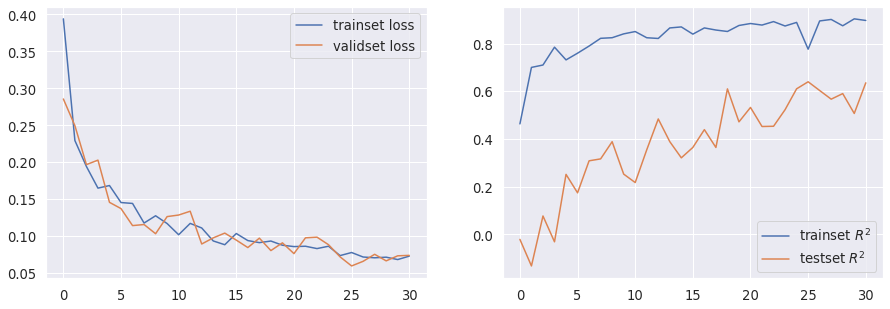

In [43]:
plot_history(model)

In [44]:
#获取最后一次保存模型的名称
latest_model_name = tf.train.latest_checkpoint("MLP")
#从路径指定的模型读取参数
model.load_weights(latest_model_name)
#评估模型
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0597 - r2_score_custom: 0.8347


[0.05970113351941109, 0.8346932530403137]

[139.40297  157.37033  187.01225  182.11826  139.73396  149.70628
 150.49603  137.50774  141.89632  127.978676 136.72115  145.3181  ]


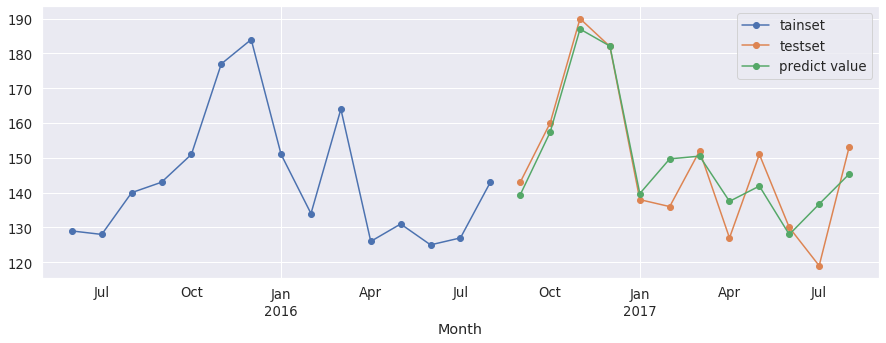

In [45]:
# 模型预测
hat = []
current = X_test[0:1]
for i in range(X_test.shape[0]):
    r = model.predict(current)
    hat.append(r[0][0])
    a = np.append(current, r, axis=1)
    current = a[:,1:]
hat = scaler.inverse_transform(np.array(hat).reshape(-1,1))
hat = hat.ravel()
print(hat)
plot_predict(hat)

In [46]:
t = scaler.inverse_transform(y_test)
print(r2_score(t.ravel(), hat))

0.8411140330962711


In [47]:
#多步输出：一次性预测12个月的值
X_size, y_size = 40, 12
X_train, y_train = create_X_y(scaled_data, X_size, y_size, 0, split)
X_test, y_test = create_X_y(scaled_data, X_size, y_size, split-X_size, scaled_data.shape[0] - y_size +1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(424, 40) (424, 12)
(1, 40) (1, 12)


In [48]:
# 构建模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, activation="relu", input_dim=X_size))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(12, activation="linear"))
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[r2_score_custom])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                780       
Total params: 14,284
Trainable params: 14,284
Non-trainable params: 0
_________________________________________________________________


In [49]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="MLP2/params.ckpt",
    monitor="val_loss",
    verbose=5,
    save_best_only=True,
    save_weights_only=True)

model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[callback, earlystop])

Epoch 1/100
46/53 [=========================>....] - ETA: 0s - loss: 0.4029 - r2_score_custom: 0.4219
Epoch 00001: val_loss improved from inf to 0.26286, saving model to MLP2/params.ckpt
53/53 [==============================] - 1s 13ms/step - loss: 0.3770 - r2_score_custom: 0.4597 - val_loss: 0.2629 - val_r2_score_custom: 0.2722
Epoch 2/100
49/53 [==========================>...] - ETA: 0s - loss: 0.1605 - r2_score_custom: 0.7756
Epoch 00002: val_loss improved from 0.26286 to 0.15911, saving model to MLP2/params.ckpt
53/53 [==============================] - 0s 7ms/step - loss: 0.1575 - r2_score_custom: 0.7825 - val_loss: 0.1591 - val_r2_score_custom: 0.5594
Epoch 3/100
48/53 [==========================>...] - ETA: 0s - loss: 0.1235 - r2_score_custom: 0.8292
Epoch 00003: val_loss improved from 0.15911 to 0.12720, saving model to MLP2/params.ckpt
53/53 [==============================] - 0s 6ms/step - loss: 0.1248 - r2_score_custom: 0.8293 - val_loss: 0.1272 - val_r2_score_custom: 0.6478
E

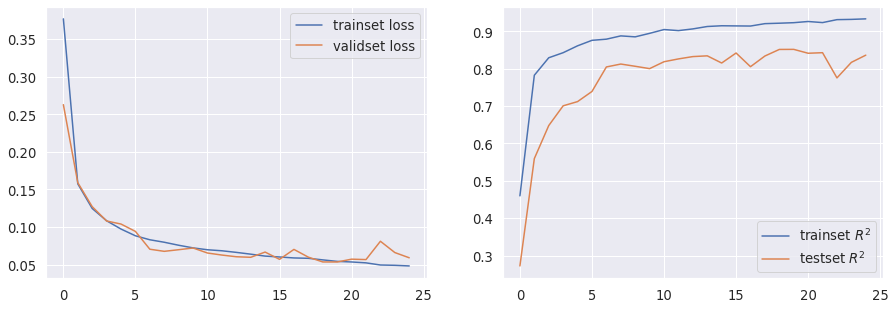

In [50]:
plot_history(model)

In [51]:
#模型评估
latest_model_name = tf.train.latest_checkpoint("MLP2")
model.load_weights(latest_model_name)
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0535 - r2_score_custom: 0.8517


[0.05354595184326172, 0.8517363667488098]

[139.42422 153.38553 187.57716 180.77353 141.15988 147.37628 152.49783
 133.05504 142.13515 127.50956 136.98964 143.47449]


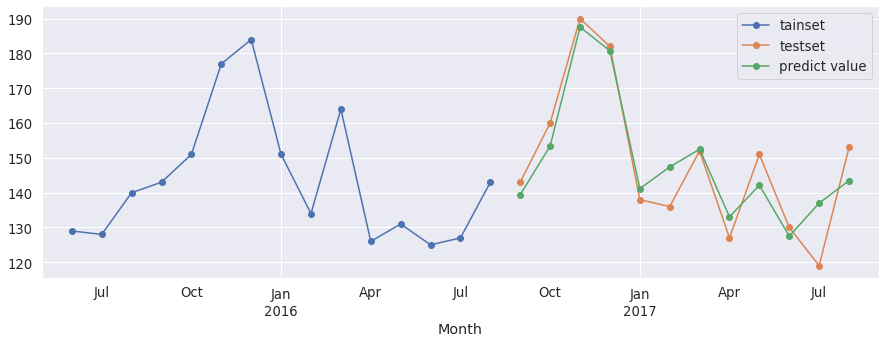

In [52]:
#预测
hat = model.predict(X_test)
hat = scaler.inverse_transform(hat)
hat = hat.ravel()
print(hat)
plot_predict(hat)

## LSTM

In [53]:
#准备lstm输入数据
X_size, y_size = 50, 12
t = scaled_data.reshape(-1, 1)
X_train, y_train = create_X_y(t, X_size, y_size, 0, split)
X_test, y_test = create_X_y(t, X_size, y_size, split-X_size, scaled_data.shape[0] - y_size +1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(414, 50, 1) (414, 12, 1)
(1, 50, 1) (1, 12, 1)


In [54]:
#构建模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(512, input_shape=X_train.shape[-2:]))
model.add(tf.keras.layers.Dense(12, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=[r2_score_custom])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1052672   
_________________________________________________________________
dense_6 (Dense)              (None, 12)                6156      
Total params: 1,058,828
Trainable params: 1,058,828
Non-trainable params: 0
_________________________________________________________________


In [66]:
#训练模型
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="LSTM/params.ckpt",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True)

model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/200
52/52 [==============================] - ETA: 0s - loss: 7.9779e-04 - r2_score_custom: 0.9989
Epoch 00001: val_loss improved from inf to 0.00918, saving model to LSTM/params.ckpt
52/52 [==============================] - 20s 386ms/step - loss: 7.9779e-04 - r2_score_custom: 0.9989 - val_loss: 0.0092 - val_r2_score_custom: 0.9746
Epoch 2/200
52/52 [==============================] - ETA: 0s - loss: 7.6803e-04 - r2_score_custom: 0.9989
Epoch 00002: val_loss did not improve from 0.00918
52/52 [==============================] - 22s 420ms/step - loss: 7.6803e-04 - r2_score_custom: 0.9989 - val_loss: 0.0109 - val_r2_score_custom: 0.9699
Epoch 3/200
52/52 [==============================] - ETA: 0s - loss: 6.5174e-04 - r2_score_custom: 0.9990
Epoch 00003: val_loss did not improve from 0.00918
52/52 [==============================] - 16s 311ms/step - loss: 6.5174e-04 - r2_score_custom: 0.9990 - val_loss: 0.0114 - val_r2_score_custom: 0.9685
Epoch 4/200
52/52 [==========================

Epoch 28/200
52/52 [==============================] - ETA: 0s - loss: 0.0021 - r2_score_custom: 0.9968
Epoch 00028: val_loss did not improve from 0.00871
52/52 [==============================] - 17s 320ms/step - loss: 0.0021 - r2_score_custom: 0.9968 - val_loss: 0.0181 - val_r2_score_custom: 0.9498
Epoch 29/200
52/52 [==============================] - ETA: 0s - loss: 0.0016 - r2_score_custom: 0.9977
Epoch 00029: val_loss did not improve from 0.00871
52/52 [==============================] - 18s 344ms/step - loss: 0.0016 - r2_score_custom: 0.9977 - val_loss: 0.0164 - val_r2_score_custom: 0.9545
Epoch 30/200
52/52 [==============================] - ETA: 0s - loss: 0.0012 - r2_score_custom: 0.9982
Epoch 00030: val_loss did not improve from 0.00871
52/52 [==============================] - 16s 305ms/step - loss: 0.0012 - r2_score_custom: 0.9982 - val_loss: 0.0143 - val_r2_score_custom: 0.9603
Epoch 31/200
52/52 [==============================] - ETA: 0s - loss: 8.8691e-04 - r2_score_custom: 

Epoch 55/200
52/52 [==============================] - ETA: 0s - loss: 0.0013 - r2_score_custom: 0.9981
Epoch 00055: val_loss did not improve from 0.00871
52/52 [==============================] - 12s 234ms/step - loss: 0.0013 - r2_score_custom: 0.9981 - val_loss: 0.0149 - val_r2_score_custom: 0.9588
Epoch 56/200
52/52 [==============================] - ETA: 0s - loss: 0.0011 - r2_score_custom: 0.9983
Epoch 00056: val_loss did not improve from 0.00871
52/52 [==============================] - 14s 272ms/step - loss: 0.0011 - r2_score_custom: 0.9983 - val_loss: 0.0142 - val_r2_score_custom: 0.9606
Epoch 57/200
52/52 [==============================] - ETA: 0s - loss: 0.0010 - r2_score_custom: 0.9985
Epoch 00057: val_loss did not improve from 0.00871
52/52 [==============================] - 16s 300ms/step - loss: 0.0010 - r2_score_custom: 0.9985 - val_loss: 0.0115 - val_r2_score_custom: 0.9683
Epoch 58/200
52/52 [==============================] - ETA: 0s - loss: 8.1889e-04 - r2_score_custom: 

Epoch 82/200
52/52 [==============================] - ETA: 0s - loss: 6.9831e-04 - r2_score_custom: 0.9990
Epoch 00082: val_loss did not improve from 0.00871
52/52 [==============================] - 17s 329ms/step - loss: 6.9831e-04 - r2_score_custom: 0.9990 - val_loss: 0.0130 - val_r2_score_custom: 0.9641
Epoch 83/200
52/52 [==============================] - ETA: 0s - loss: 6.2527e-04 - r2_score_custom: 0.9991
Epoch 00083: val_loss did not improve from 0.00871
52/52 [==============================] - 14s 273ms/step - loss: 6.2527e-04 - r2_score_custom: 0.9991 - val_loss: 0.0138 - val_r2_score_custom: 0.9618
Epoch 84/200
52/52 [==============================] - ETA: 0s - loss: 5.2091e-04 - r2_score_custom: 0.9992
Epoch 00084: val_loss did not improve from 0.00871
52/52 [==============================] - 17s 325ms/step - loss: 5.2091e-04 - r2_score_custom: 0.9992 - val_loss: 0.0157 - val_r2_score_custom: 0.9564
Epoch 85/200
52/52 [==============================] - ETA: 0s - loss: 6.2028

Epoch 109/200
52/52 [==============================] - ETA: 0s - loss: 5.5562e-04 - r2_score_custom: 0.9992
Epoch 00109: val_loss did not improve from 0.00871
52/52 [==============================] - 12s 240ms/step - loss: 5.5562e-04 - r2_score_custom: 0.9992 - val_loss: 0.0137 - val_r2_score_custom: 0.9621
Epoch 110/200
52/52 [==============================] - ETA: 0s - loss: 5.5231e-04 - r2_score_custom: 0.9992
Epoch 00110: val_loss did not improve from 0.00871
52/52 [==============================] - 16s 301ms/step - loss: 5.5231e-04 - r2_score_custom: 0.9992 - val_loss: 0.0141 - val_r2_score_custom: 0.9609
Epoch 111/200
52/52 [==============================] - ETA: 0s - loss: 5.3730e-04 - r2_score_custom: 0.9993
Epoch 00111: val_loss did not improve from 0.00871
52/52 [==============================] - 15s 293ms/step - loss: 5.3730e-04 - r2_score_custom: 0.9993 - val_loss: 0.0135 - val_r2_score_custom: 0.9626
Epoch 112/200
52/52 [==============================] - ETA: 0s - loss: 5.

Epoch 136/200
52/52 [==============================] - ETA: 0s - loss: 5.9061e-04 - r2_score_custom: 0.9991
Epoch 00136: val_loss did not improve from 0.00871
52/52 [==============================] - 16s 312ms/step - loss: 5.9061e-04 - r2_score_custom: 0.9991 - val_loss: 0.0137 - val_r2_score_custom: 0.9620
Epoch 137/200
52/52 [==============================] - ETA: 0s - loss: 5.2822e-04 - r2_score_custom: 0.9993
Epoch 00137: val_loss did not improve from 0.00871
52/52 [==============================] - 14s 273ms/step - loss: 5.2822e-04 - r2_score_custom: 0.9993 - val_loss: 0.0145 - val_r2_score_custom: 0.9599
Epoch 138/200
52/52 [==============================] - ETA: 0s - loss: 4.9861e-04 - r2_score_custom: 0.9993
Epoch 00138: val_loss did not improve from 0.00871
52/52 [==============================] - 17s 320ms/step - loss: 4.9861e-04 - r2_score_custom: 0.9993 - val_loss: 0.0134 - val_r2_score_custom: 0.9629
Epoch 139/200
52/52 [==============================] - ETA: 0s - loss: 4.

Epoch 163/200
52/52 [==============================] - ETA: 0s - loss: 0.0171 - r2_score_custom: 0.9735
Epoch 00163: val_loss did not improve from 0.00871
52/52 [==============================] - 18s 350ms/step - loss: 0.0171 - r2_score_custom: 0.9735 - val_loss: 0.0182 - val_r2_score_custom: 0.9496
Epoch 164/200
52/52 [==============================] - ETA: 0s - loss: 0.0038 - r2_score_custom: 0.9947
Epoch 00164: val_loss did not improve from 0.00871
52/52 [==============================] - 21s 395ms/step - loss: 0.0038 - r2_score_custom: 0.9947 - val_loss: 0.0159 - val_r2_score_custom: 0.9560
Epoch 165/200
52/52 [==============================] - ETA: 0s - loss: 0.0015 - r2_score_custom: 0.9978
Epoch 00165: val_loss did not improve from 0.00871
52/52 [==============================] - 17s 320ms/step - loss: 0.0015 - r2_score_custom: 0.9978 - val_loss: 0.0189 - val_r2_score_custom: 0.9476
Epoch 166/200
52/52 [==============================] - ETA: 0s - loss: 8.4386e-04 - r2_score_cust

Epoch 190/200
52/52 [==============================] - ETA: 0s - loss: 1.6127e-05 - r2_score_custom: 1.0000
Epoch 00190: val_loss did not improve from 0.00871
52/52 [==============================] - 13s 251ms/step - loss: 1.6127e-05 - r2_score_custom: 1.0000 - val_loss: 0.0169 - val_r2_score_custom: 0.9532
Epoch 191/200
52/52 [==============================] - ETA: 0s - loss: 1.5372e-05 - r2_score_custom: 1.0000
Epoch 00191: val_loss did not improve from 0.00871
52/52 [==============================] - 12s 238ms/step - loss: 1.5372e-05 - r2_score_custom: 1.0000 - val_loss: 0.0168 - val_r2_score_custom: 0.9535
Epoch 192/200
52/52 [==============================] - ETA: 0s - loss: 1.4137e-05 - r2_score_custom: 1.0000
Epoch 00192: val_loss did not improve from 0.00871
52/52 [==============================] - 16s 303ms/step - loss: 1.4137e-05 - r2_score_custom: 1.0000 - val_loss: 0.0168 - val_r2_score_custom: 0.9534
Epoch 193/200
52/52 [==============================] - ETA: 0s - loss: 1.

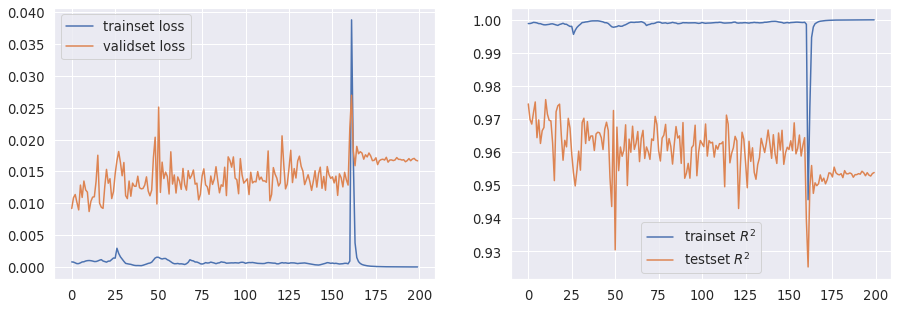

In [67]:
plot_history(model)

In [68]:
#评估模型
latest_model_name = tf.train.latest_checkpoint("LSTM")
# print(latest_model_name)
model.load_weights(latest_model_name)
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0087 - r2_score_custom: 0.9759


[0.008706391789019108, 0.9758928418159485]

[142.71399 160.85507 185.34612 181.80841 135.29922 136.12514 154.54037
 124.74055 146.82527 130.86424 124.77562 147.77403]


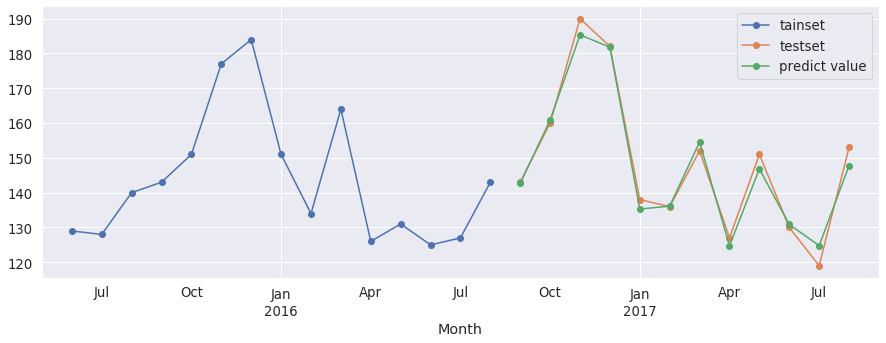

In [69]:
#预测
hat = model.predict(X_test)
hat = scaler.inverse_transform(hat)
hat = hat.ravel()
print(hat)
plot_predict(hat)

### GRU

In [70]:
#构建模型
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(512, input_shape=X_train.shape[-2:]))
model.add(tf.keras.layers.Dense(12, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=[r2_score_custom])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 512)               791040    
_________________________________________________________________
dense_7 (Dense)              (None, 12)                6156      
Total params: 797,196
Trainable params: 797,196
Non-trainable params: 0
_________________________________________________________________


In [71]:
#训练模型
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "GRU/params.ckpt",
    monitor = "val_loss",
    verbose =1,
    save_best_only=True,
    save_weights_only=True)

model.fit(X_train, y_train, epochs=200, batch_size=8, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/200
52/52 [==============================] - ETA: 0s - loss: 0.3120 - r2_score_custom: 0.5700
Epoch 00001: val_loss improved from inf to 0.17885, saving model to GRU/params.ckpt
52/52 [==============================] - 18s 354ms/step - loss: 0.3120 - r2_score_custom: 0.5700 - val_loss: 0.1789 - val_r2_score_custom: 0.5048
Epoch 2/200
52/52 [==============================] - ETA: 0s - loss: 0.1645 - r2_score_custom: 0.7555
Epoch 00002: val_loss did not improve from 0.17885
52/52 [==============================] - 15s 287ms/step - loss: 0.1645 - r2_score_custom: 0.7555 - val_loss: 0.1967 - val_r2_score_custom: 0.4553
Epoch 3/200
52/52 [==============================] - ETA: 0s - loss: 0.1540 - r2_score_custom: 0.7694
Epoch 00003: val_loss improved from 0.17885 to 0.15031, saving model to GRU/params.ckpt
52/52 [==============================] - 15s 281ms/step - loss: 0.1540 - r2_score_custom: 0.7694 - val_loss: 0.1503 - val_r2_score_custom: 0.5838
Epoch 4/200
52/52 [==============

Epoch 28/200
52/52 [==============================] - ETA: 0s - loss: 0.0505 - r2_score_custom: 0.9244
Epoch 00028: val_loss improved from 0.05532 to 0.05458, saving model to GRU/params.ckpt
52/52 [==============================] - 15s 291ms/step - loss: 0.0505 - r2_score_custom: 0.9244 - val_loss: 0.0546 - val_r2_score_custom: 0.8489
Epoch 29/200
52/52 [==============================] - ETA: 0s - loss: 0.0485 - r2_score_custom: 0.9245
Epoch 00029: val_loss improved from 0.05458 to 0.04775, saving model to GRU/params.ckpt
52/52 [==============================] - 17s 322ms/step - loss: 0.0485 - r2_score_custom: 0.9245 - val_loss: 0.0478 - val_r2_score_custom: 0.8678
Epoch 30/200
52/52 [==============================] - ETA: 0s - loss: 0.0475 - r2_score_custom: 0.9284
Epoch 00030: val_loss improved from 0.04775 to 0.04379, saving model to GRU/params.ckpt
52/52 [==============================] - 18s 351ms/step - loss: 0.0475 - r2_score_custom: 0.9284 - val_loss: 0.0438 - val_r2_score_cust

52/52 [==============================] - ETA: 0s - loss: 0.0068 - r2_score_custom: 0.9900
Epoch 00054: val_loss did not improve from 0.02919
52/52 [==============================] - 15s 290ms/step - loss: 0.0068 - r2_score_custom: 0.9900 - val_loss: 0.0319 - val_r2_score_custom: 0.9116
Epoch 55/200
52/52 [==============================] - ETA: 0s - loss: 0.0062 - r2_score_custom: 0.9911
Epoch 00055: val_loss did not improve from 0.02919
52/52 [==============================] - 16s 312ms/step - loss: 0.0062 - r2_score_custom: 0.9911 - val_loss: 0.0338 - val_r2_score_custom: 0.9063
Epoch 56/200
52/52 [==============================] - ETA: 0s - loss: 0.0058 - r2_score_custom: 0.9917
Epoch 00056: val_loss did not improve from 0.02919
52/52 [==============================] - 19s 371ms/step - loss: 0.0058 - r2_score_custom: 0.9917 - val_loss: 0.0345 - val_r2_score_custom: 0.9046
Epoch 57/200
52/52 [==============================] - ETA: 0s - loss: 0.0049 - r2_score_custom: 0.9932
Epoch 0005

Epoch 81/200
52/52 [==============================] - ETA: 0s - loss: 0.0019 - r2_score_custom: 0.9973
Epoch 00081: val_loss did not improve from 0.02255
52/52 [==============================] - 22s 420ms/step - loss: 0.0019 - r2_score_custom: 0.9973 - val_loss: 0.0259 - val_r2_score_custom: 0.9282
Epoch 82/200
52/52 [==============================] - ETA: 0s - loss: 0.0021 - r2_score_custom: 0.9968
Epoch 00082: val_loss did not improve from 0.02255
52/52 [==============================] - 27s 519ms/step - loss: 0.0021 - r2_score_custom: 0.9968 - val_loss: 0.0251 - val_r2_score_custom: 0.9305
Epoch 83/200
52/52 [==============================] - ETA: 0s - loss: 0.0025 - r2_score_custom: 0.9964
Epoch 00083: val_loss improved from 0.02255 to 0.02005, saving model to GRU/params.ckpt
52/52 [==============================] - 22s 430ms/step - loss: 0.0025 - r2_score_custom: 0.9964 - val_loss: 0.0200 - val_r2_score_custom: 0.9445
Epoch 84/200
52/52 [==============================] - ETA: 0s -

52/52 [==============================] - ETA: 0s - loss: 0.0016 - r2_score_custom: 0.9977
Epoch 00108: val_loss did not improve from 0.01935
52/52 [==============================] - 21s 407ms/step - loss: 0.0016 - r2_score_custom: 0.9977 - val_loss: 0.0257 - val_r2_score_custom: 0.9289
Epoch 109/200
52/52 [==============================] - ETA: 0s - loss: 0.0023 - r2_score_custom: 0.9968
Epoch 00109: val_loss did not improve from 0.01935
52/52 [==============================] - 25s 483ms/step - loss: 0.0023 - r2_score_custom: 0.9968 - val_loss: 0.0238 - val_r2_score_custom: 0.9341
Epoch 110/200
52/52 [==============================] - ETA: 0s - loss: 0.0031 - r2_score_custom: 0.9956
Epoch 00110: val_loss did not improve from 0.01935
52/52 [==============================] - 17s 322ms/step - loss: 0.0031 - r2_score_custom: 0.9956 - val_loss: 0.0262 - val_r2_score_custom: 0.9274
Epoch 111/200
52/52 [==============================] - ETA: 0s - loss: 0.0028 - r2_score_custom: 0.9960
Epoch 0

52/52 [==============================] - ETA: 0s - loss: 0.0019 - r2_score_custom: 0.9973
Epoch 00135: val_loss did not improve from 0.01594
52/52 [==============================] - 18s 355ms/step - loss: 0.0019 - r2_score_custom: 0.9973 - val_loss: 0.0223 - val_r2_score_custom: 0.9382
Epoch 136/200
52/52 [==============================] - ETA: 0s - loss: 0.0023 - r2_score_custom: 0.9967
Epoch 00136: val_loss did not improve from 0.01594
52/52 [==============================] - 18s 352ms/step - loss: 0.0023 - r2_score_custom: 0.9967 - val_loss: 0.0237 - val_r2_score_custom: 0.9343
Epoch 137/200
52/52 [==============================] - ETA: 0s - loss: 0.0018 - r2_score_custom: 0.9973
Epoch 00137: val_loss did not improve from 0.01594
52/52 [==============================] - 14s 276ms/step - loss: 0.0018 - r2_score_custom: 0.9973 - val_loss: 0.0214 - val_r2_score_custom: 0.9408
Epoch 138/200
52/52 [==============================] - ETA: 0s - loss: 0.0013 - r2_score_custom: 0.9982
Epoch 0

52/52 [==============================] - ETA: 0s - loss: 0.0017 - r2_score_custom: 0.9975
Epoch 00162: val_loss did not improve from 0.01594
52/52 [==============================] - 17s 324ms/step - loss: 0.0017 - r2_score_custom: 0.9975 - val_loss: 0.0174 - val_r2_score_custom: 0.9519
Epoch 163/200
52/52 [==============================] - ETA: 0s - loss: 0.0014 - r2_score_custom: 0.9981
Epoch 00163: val_loss did not improve from 0.01594
52/52 [==============================] - 18s 350ms/step - loss: 0.0014 - r2_score_custom: 0.9981 - val_loss: 0.0218 - val_r2_score_custom: 0.9397
Epoch 164/200
52/52 [==============================] - ETA: 0s - loss: 0.0012 - r2_score_custom: 0.9984
Epoch 00164: val_loss did not improve from 0.01594
52/52 [==============================] - 13s 254ms/step - loss: 0.0012 - r2_score_custom: 0.9984 - val_loss: 0.0185 - val_r2_score_custom: 0.9487
Epoch 165/200
52/52 [==============================] - ETA: 0s - loss: 0.0011 - r2_score_custom: 0.9983
Epoch 0

52/52 [==============================] - ETA: 0s - loss: 4.7532e-04 - r2_score_custom: 0.9993
Epoch 00189: val_loss did not improve from 0.01594
52/52 [==============================] - 13s 245ms/step - loss: 4.7532e-04 - r2_score_custom: 0.9993 - val_loss: 0.0182 - val_r2_score_custom: 0.9497
Epoch 190/200
52/52 [==============================] - ETA: 0s - loss: 6.2965e-04 - r2_score_custom: 0.9991
Epoch 00190: val_loss did not improve from 0.01594
52/52 [==============================] - 16s 311ms/step - loss: 6.2965e-04 - r2_score_custom: 0.9991 - val_loss: 0.0207 - val_r2_score_custom: 0.9428
Epoch 191/200
52/52 [==============================] - ETA: 0s - loss: 7.1000e-04 - r2_score_custom: 0.9990
Epoch 00191: val_loss did not improve from 0.01594
52/52 [==============================] - 16s 311ms/step - loss: 7.1000e-04 - r2_score_custom: 0.9990 - val_loss: 0.0219 - val_r2_score_custom: 0.9395
Epoch 192/200
52/52 [==============================] - ETA: 0s - loss: 9.6646e-04 - r2_

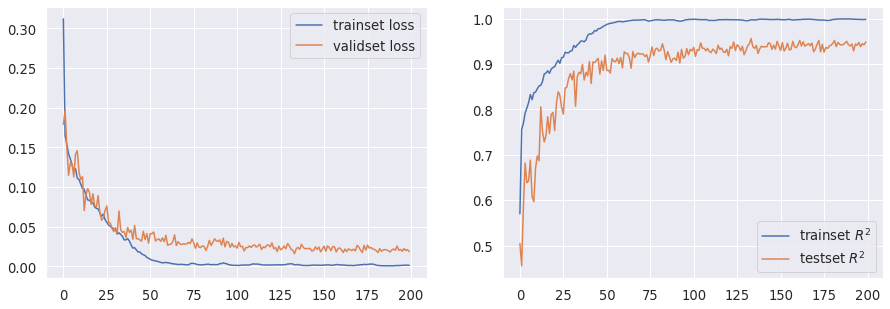

In [72]:
plot_history(model)

In [73]:
#模型评估
latest_model_name = tf.train.latest_checkpoint("GRU")
model.load_weights(latest_model_name)
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.0159 - r2_score_custom: 0.9559


[0.015939228236675262, 0.9558658003807068]

[141.1739  160.63177 188.8275  182.99982 141.55998 140.37515 151.14543
 129.4806  149.20767 125.88696 127.02205 143.47092]


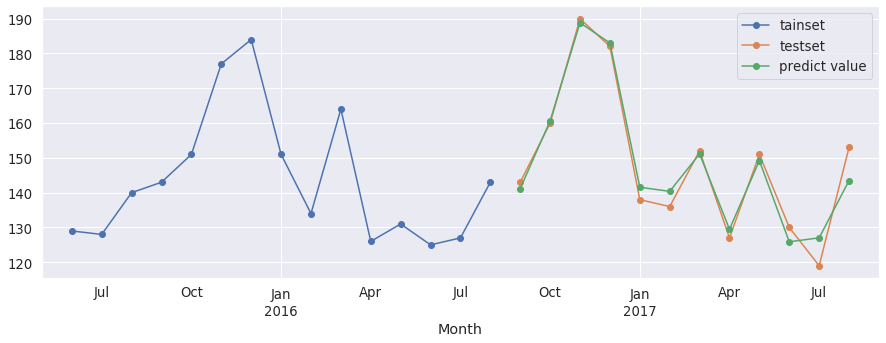

In [74]:
#预测
hat = model.predict(X_test)
hat = scaler.inverse_transform(hat)
hat = hat.ravel()
print(hat)
plot_predict(hat)